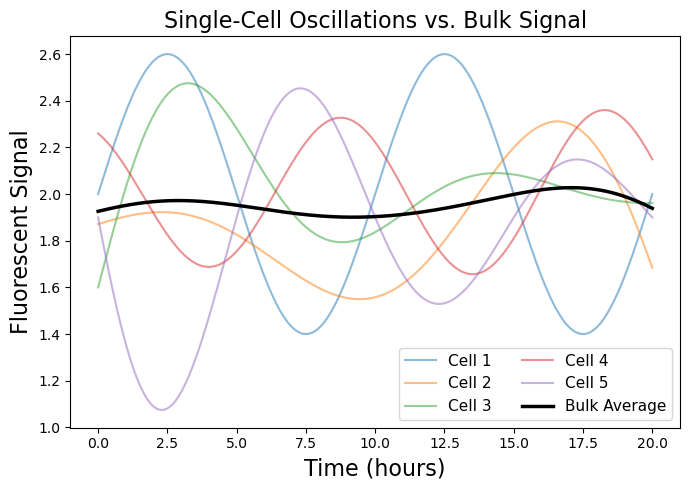

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Time vector
t = np.linspace(0, 20, 1000)  # 20 hours

# Hard-coded heterogeneity including slow, damped, and flat cells
params = [
    {"amp": 0.6, "freq": 0.10,  "phase": 0.0,       "offset": 2.0,  "decay": 0.00},
    {"amp": 0.1, "freq": 0.07,  "phase": np.pi/4,   "offset": 1.8,  "decay": -0.10},
    {"amp": 0.8, "freq": 0.09,  "phase": -np.pi/6,   "offset": 2.0,  "decay": 0.15},
    {"amp": 0.3, "freq": 0.105, "phase": np.pi/1.5,     "offset": 2.0,  "decay": -0.01},
    {"amp": 1.0, "freq": 0.1,   "phase": np.pi, "offset": 1.9,  "decay": 0.08}
]

signals = []
for p in params:
    sig = (p["amp"] * np.sin(2 * np.pi * p["freq"] * t + p["phase"])
           * np.exp(-p["decay"] * t) + p["offset"])
    signals.append(sig)

signals = np.array(signals)
average_signal = signals.mean(axis=0)

# Plot
plt.figure(figsize=(7, 5))
for idx, sig in enumerate(signals):
    label = f'Cell {idx+1}'
    plt.plot(t, sig, label=label, alpha=0.5, linewidth=1.5)

plt.plot(t, average_signal, color='black', linewidth=2.5, label='Bulk Average')
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Fluorescent Signal', fontsize=16)
plt.title("Single-Cell Oscillations vs. Bulk Signal", fontsize=16)
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
plt.show()


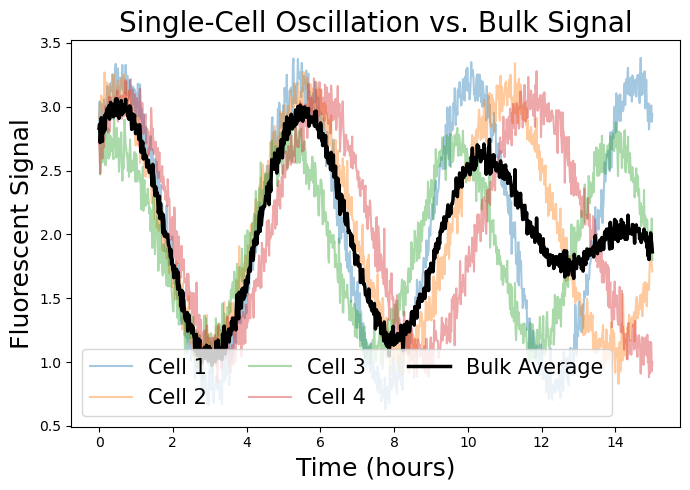

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Time vector
t = np.linspace(0, 15, 1000)  # 20 hours

# Hard-coded heterogeneity: constant amplitude noisy oscillators
params = [
    {"amp": 1.2, "freq0": 0.2,  "drift": 0.002, "phase": np.pi/4,        "offset": 2.0},
    {"amp": 1.0, "freq0": 0.2,  "drift": -0.002,"phase": np.pi/3,   "offset": 2.1},
    {"amp": 0.8, "freq0": 0.2,  "drift": 0.003, "phase": np.pi/3,   "offset": 1.9},
    {"amp": 1.0, "freq0": 0.2,  "drift": -0.003,"phase": np.pi/5, "offset": 2.05},
    # {"amp": 1.0, "freq0": 0.2,  "drift": 0.0006,"phase": np.pi/4,     "offset": 2.0},
]

# Generate single-cell signals
signals = []
for p in params:
    freq = p["freq0"] + p["drift"] * t
    phase_integral = 2 * np.pi * np.cumsum(freq) * (t[1] - t[0])
    noise = np.random.normal(scale=0.1, size=t.size)
    sig = p["amp"] * np.sin(phase_integral + p["phase"]) + p["offset"] + noise
    signals.append(sig)

signals = np.array(signals)
average_signal = signals.mean(axis=0)

# Apply explicit damping to the bulk average
bulk_decay = 0  # stronger damping factor
damped_average = average_signal * np.exp(-bulk_decay * t)   # add baseline to maintain offset

# Plot
plt.figure(figsize=(7, 5))
for idx, sig in enumerate(signals):
    plt.plot(t, sig, label=f'Cell {idx+1}', alpha=0.4)

plt.plot(t, damped_average, color='black', linewidth=2.5, label='Bulk Average')
plt.xlabel('Time (hours)', fontsize=18)
plt.ylabel('Fluorescent Signal', fontsize=18)
plt.title("Single-Cell Oscillation vs. Bulk Signal", fontsize=20)
plt.legend(fontsize=15, ncol=3)
plt.tight_layout()
plt.show()


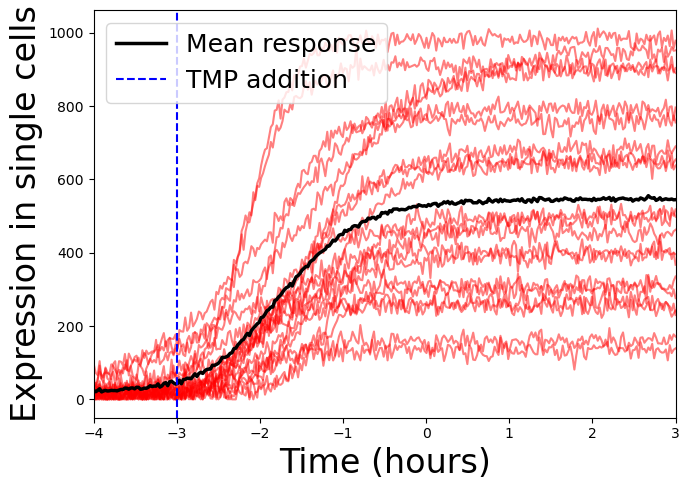

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Time vector from -4 to +3 hours
t = np.linspace(-4, 3, 300)

# Number of single-cell traces
n_cells = 20

# Time of TMP addition
t_add = -3

# Generate synthetic single-cell expression trajectories
trajectories = []
for _ in range(n_cells):
    delay = np.random.uniform(0.5, 2.0)
    slope = np.random.uniform(1, 4)
    baseline = np.random.normal(10, 3)
    max_expr = np.random.uniform(100, 1000)

    expr = baseline + (max_expr / (1 + np.exp(-slope * (t - (t_add + delay)))))
    expr += np.random.normal(scale=15, size=t.shape)
    expr = np.clip(expr, 0, None)
    
    trajectories.append(expr)

trajectories = np.array(trajectories)

# Compute mean trajectory
mean_trajectory = np.mean(trajectories, axis=0)

# Compute a representative trajectory for highlighting
highlight_idx = 0
highlight_traj = trajectories[highlight_idx]

# Expression values at key times for highlighting
expr_add = np.interp(t_add, t, highlight_traj)
expr_zero = np.interp(0, t, highlight_traj)

# Plotting
plt.figure(figsize=(7, 5))
for traj in trajectories:
    plt.plot(t, traj, color='red', alpha=0.5)

# Plot mean trajectory
plt.plot(t, mean_trajectory, color='black', linewidth=2.5, label='Mean response')

# Vertical line for TMP addition
plt.axvline(x=t_add, color='blue', linestyle='--', linewidth=1.5, label='TMP addition')

# Highlighted trajectory marker dots
# plt.scatter([t_add, 0], [expr_add, expr_zero], color='yellow', edgecolor='black', zorder=5)

# Labels and formatting
plt.xlabel('Time (hours)', fontsize=24)
plt.ylabel('Expression in single cells', fontsize=24)
plt.legend(fontsize=18)
plt.ylim(-50, np.max(trajectories) * 1.05)
plt.xlim(-4, 3)
plt.tight_layout()
plt.show()


C:\Users\kastu\AppData\Local\Temp\ipykernel_86540\3335576576.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


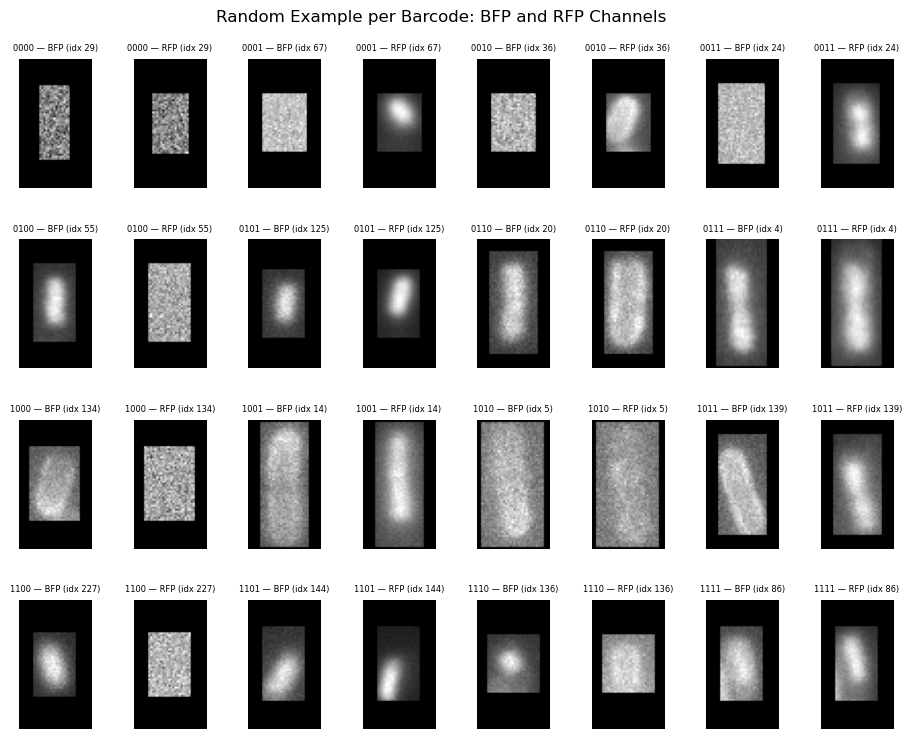

In [40]:
import os
import zarr
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ── 1) Paths ────────────────────────────────────────────────────────
BASE      = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_DIR  = os.path.join(BASE, "test_sets")

# ── 2) Gather barcode Zarrs ─────────────────────────────────────────
files    = sorted(f for f in os.listdir(TEST_DIR) if f.endswith("_test.zarr"))
barcodes = [f[:4] for f in files]  # e.g. "0010", "1111", …

# ── 3) Prepare A4-landscape figure ──────────────────────────────────
fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape in inches
gs  = gridspec.GridSpec(4, 8, wspace=0.1, hspace=0.4)

# ── 4) Loop over each barcode and plot a random sample ───────────────
for idx, fname in enumerate(files):
    bc   = barcodes[idx]
    path = os.path.join(TEST_DIR, fname)
    z    = zarr.open(path, mode="r")

    # Choose a random cell index for this barcode
    n_cells    = z["bfp"].shape[0]
    sample_idx = random.randint(0, n_cells - 1)

    # Load and normalize the BFP and RFP images
    bfp = z["bfp"][sample_idx].astype(np.float32)
    rfp = z["rfp"][sample_idx].astype(np.float32)
    bfp = (bfp - bfp.min()) / (bfp.ptp() + 1e-8)
    rfp = (rfp - rfp.min()) / (rfp.ptp() + 1e-8)

    # Determine grid position
    row = idx // 4
    col = idx % 4

    # Plot BFP channel
    ax_b = fig.add_subplot(gs[row, col*2])
    ax_b.imshow(bfp, cmap="gray")
    ax_b.axis("off")
    ax_b.set_title(f"{bc} — BFP (idx {sample_idx})", fontsize=6)

    # Plot RFP channel
    ax_r = fig.add_subplot(gs[row, col*2 + 1])
    ax_r.imshow(rfp, cmap="gray")
    ax_r.axis("off")
    ax_r.set_title(f"{bc} — RFP (idx {sample_idx})", fontsize=6)

# ── 5) Final layout tweaks ────────────────────────────────────────────
fig.suptitle("Random Example per Barcode: BFP and RFP Channels", fontsize=12)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()


C:\Users\kastu\AppData\Local\Temp\ipykernel_86540\1873856706.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


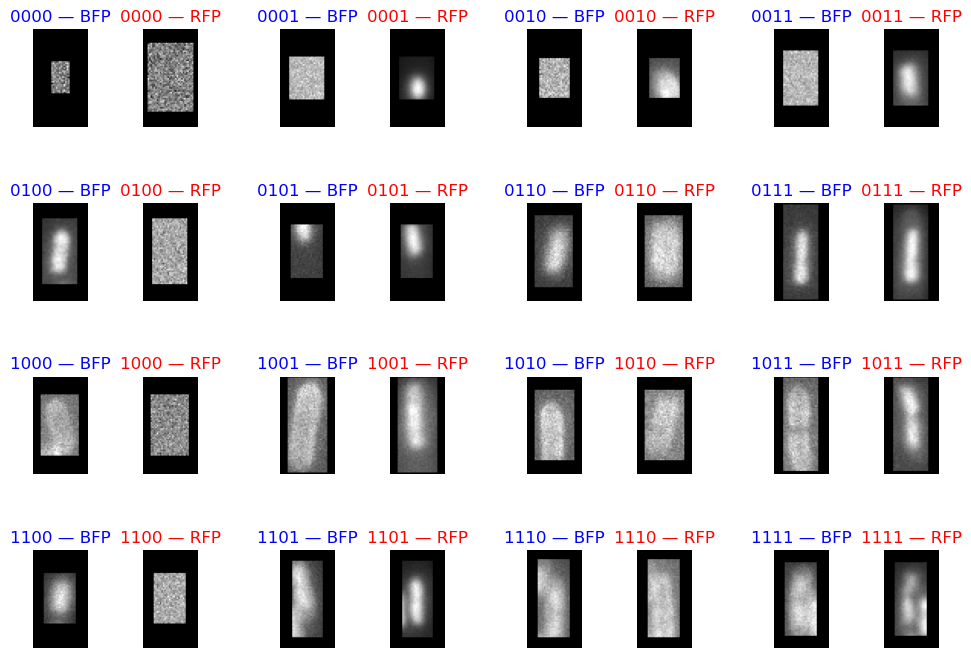

In [175]:
import os
import zarr
import numpy as np
import random
import matplotlib.pyplot as plt

# ── 1) Paths ────────────────────────────────────────────────────────
BASE     = r"D:\PRISM\Mother Cell For PRISM Train"
TEST_DIR = os.path.join(BASE, "test_sets")

# ── 2) Gather barcode Zarrs ─────────────────────────────────────────
files    = sorted(f for f in os.listdir(TEST_DIR) if f.endswith("_test.zarr"))
barcodes = [f[:4] for f in files]  # e.g. "0010", "1111", …

# Optional: seed for reproducibility
# random.seed(42)

# ── 3) Prepare A4-landscape figure with outer grid ─────────────────
fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape in inches
outer = fig.add_gridspec(4, 4, wspace=0.5, hspace=0.5)

# ── 4) Loop over each barcode and plot a random sample ─────────────
for idx, fname in enumerate(files):
    bc   = barcodes[idx]
    path = os.path.join(TEST_DIR, fname)
    z    = zarr.open(path, mode="r")

    # Choose a random cell index for this barcode
    n_cells    = z["bfp"].shape[0]
    sample_idx = random.randint(0, n_cells - 1)

    # Load and normalize the BFP and RFP images
    bfp = z["bfp"][sample_idx].astype(np.float32)
    rfp = z["rfp"][sample_idx].astype(np.float32)
    bfp = (bfp - bfp.min()) / (bfp.ptp() + 1e-8)
    rfp = (rfp - rfp.min()) / (rfp.ptp() + 1e-8)

    # Determine position in outer grid
    row = idx // 4
    col = idx % 4

    # Create inner grid for the two channels with reduced spacing
    inner = outer[row, col].subgridspec(1, 2, wspace=1, hspace=1)

    # Plot BFP channel
    ax_b = fig.add_subplot(inner[0, 0])
    ax_b.imshow(bfp, cmap="gray")
    ax_b.set_title(f"{bc} — BFP", fontsize=12, color='blue')
    ax_b.axis("off")
    # Color frame blue
    for spine in ax_b.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(2)

    # Plot RFP channel
    ax_r = fig.add_subplot(inner[0, 1])
    ax_r.imshow(rfp, cmap="gray")
    ax_r.set_title(f"{bc} — RFP", fontsize=12, color='red')
    ax_r.axis("off")
    # Color frame red
    for spine in ax_r.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)

# ── 5) Final layout tweaks ────────────────────────────────────────────
# fig.suptitle("Random Example per Barcode: BFP and RFP Channels", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [182]:
import os
import zarr

# 1) Recursively find all "<barcode>_accepted_mother" folders under cwd
accepted_dirs = []
for root, dirs, _ in os.walk(os.getcwd()):
    for d in dirs:
        if d.endswith("_accepted_mother"):
            accepted_dirs.append(os.path.join(root, d))

if not accepted_dirs:
    print("⚠️ No '*_accepted_mother' directories were found under", os.getcwd())
    exit(1)

# 2) Helper to pick which array holds the per-cell stack
def pick_cell_array(group):
    for name in ("bfp", "rfp", "pc"):
        if name in group:
            return name
    raise KeyError(f"No known cell array in {list(group.keys())}")

# 3) Count cells in each folder
counts = {}
total  = 0

for folder in sorted(accepted_dirs):
    barcode = os.path.basename(folder).split("_")[0]
    n_cells = 0

    for fname in os.listdir(folder):
        if not fname.endswith(".zarr"):
            continue
        grp = zarr.open(os.path.join(folder, fname), mode="r")
        arr = pick_cell_array(grp)
        n_cells += grp[arr].shape[0]

    counts[barcode] = n_cells
    total += n_cells

# 4) Print results
print(f"Total cells across all barcodes: {total}\n")
print("Cells per barcode:")
for bc in sorted(counts):
    print(f"  {bc}: {counts[bc]}")


⚠️ No '*_accepted_mother' directories were found under d:\PRISM\Report_Figure
Total cells across all barcodes: 0

Cells per barcode:
